In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import models, layers
from keras.utils import to_categorical
from keras import optimizers
from keras import losses
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dense, Dropout
from keras.regularizers import l2
import time as t

# Multi-class classification

In [2]:
def one_hot_encoding(labels):
    return pd.get_dummies(labels)

def load_iris_data(df):
    dataframe = pd.read_csv(df,delim_whitespace = False,header=None)
    dataframe = dataframe.replace("?",np.NAN)
    dataframe = dataframe.sample(frac=1)
    dataframe = dataframe.values
    x = dataframe[:,:4]
    x = np.asarray(x).astype('float32')
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    x_train = dataframe[:105,:4]
    x_test = dataframe[105:,:4]
    x_train -= mean
    x_train /= std
    x_test -= mean
    x_test /= std
    y_train = one_hot_encoding(dataframe[:105,4])
    y_test = one_hot_encoding(dataframe[105:,4])
    x_train = np.asarray(x_train).astype('float32')
    y_train = np.asarray(y_train).astype('float32')
    x_test = np.asarray(x_test).astype('float32')
    y_test = np.asarray(y_test).astype('float32')
    return x_train,y_train,x_test,y_test

In [3]:

X_train,Y_train,X_test,Y_test = load_iris_data("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")
print(X_train.shape,X_test.shape)

(105, 4) (45, 4)


In [4]:
# Step 2: Create validation set
X_val = X_train[75:]
X_train = X_train[:75]
Y_val = Y_train [75:]
Y_train = Y_train[:75]

In [5]:
# Defining a model with optimizer and loss as parameters
def build_model(opt,los):
  model = models.Sequential()
  model.add(layers.Dense(16,activation="relu",input_shape = (4,)))
  model.add(layers.Dense(16,activation="relu"))
  model.add(layers.Dense(32,activation="relu"))
  model.add(layers.Flatten())
  model.add(layers.Dense(3,activation="softmax"))
  model.compile(optimizer=str(opt),loss=str(los),metrics=["categorical_accuracy"])
  return model


2/2 [==============================] - 0s 7ms/step - loss: 0.4483 - categorical_accuracy: 0.8444
Test Results:sgd-categorical_crossentropy: [0.44827011227607727, 0.8444444537162781] 
Time Taken:6.124718189239502
2/2 [==============================] - 0s 4ms/step - loss: 0.6672 - categorical_accuracy: 0.5778
Test Results:sgd-categorical_hinge: [0.6672106981277466, 0.5777778029441833] 
Time Taken:5.48800253868103
2/2 [==============================] - 0s 7ms/step - loss: 0.5046 - categorical_accuracy: 0.8444
Test Results:sgd-kl_divergence: [0.5045613050460815, 0.8444444537162781] 
Time Taken:5.603179454803467
2/2 [==============================] - 0s 6ms/step - loss: 0.1867 - categorical_accuracy: 0.9556
Test Results:rmsprop-categorical_crossentropy: [0.18667878210544586, 0.9555555582046509] 
Time Taken:5.733550548553467
2/2 [==============================] - 0s 7ms/step - loss: 0.1748 - categorical_accuracy: 0.9333
Test Results:rmsprop-categorical_hinge: [0.1747925877571106, 0.933333337

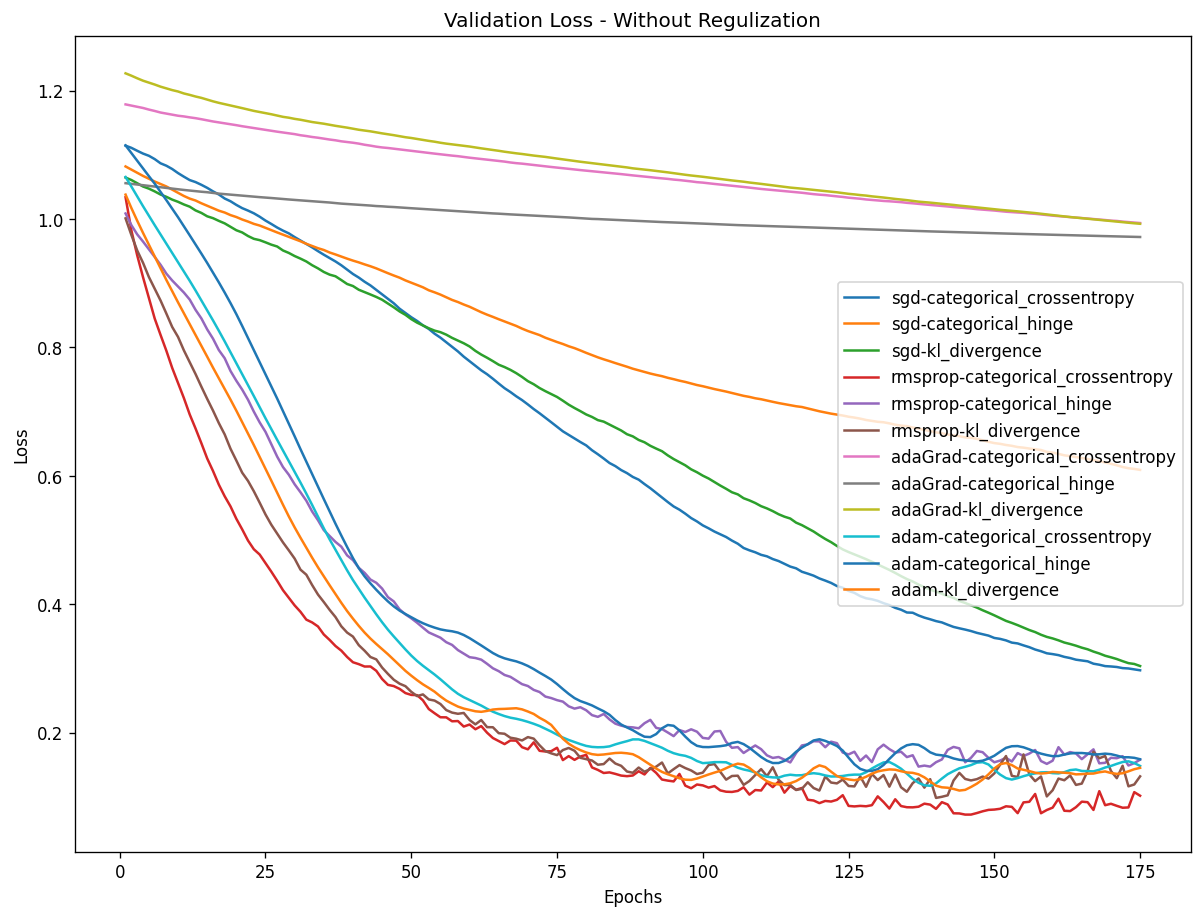

The best combination of optimizer and loss on test set after 175 epochs is adam-categorical_hinge with an loss and accuracy of [0.16467465460300446, 0.9333333373069763]


In [6]:
# Train model on different combinations of loss and optimizers
labels_optimizers = ['sgd','rmsprop','adaGrad','adam']
labels_losses = ['categorical_crossentropy','categorical_hinge','kl_divergence']
best_combo = ""
best_combo_value = float("inf")
eps = 175
plt.figure(num=None, figsize=(12, 9), dpi=120, facecolor='w', edgecolor='k')
for i, param_opt in enumerate(labels_optimizers):
  for j, param_los in enumerate(labels_losses):
    res = build_model(param_opt,param_los)
    start_time = t.time()
    res.fit(X_train,Y_train,epochs=eps,batch_size=64, validation_data=(X_val,Y_val),verbose=0)
    end_time = t.time()
    time_taken = end_time-start_time
    val_loss_values = res.history.history['val_loss']
    eval = res.evaluate(X_test,Y_test)
    if eval[0] < best_combo_value:
      best_combo_value = eval[0] 
      best_combo = labels_optimizers[i]+ '-' +labels_losses[j]
      best_eval = eval
    epochs = range(1,len(val_loss_values)+1)
    plt.plot(epochs,val_loss_values,label =  labels_optimizers[i]+ '-' +labels_losses[j])
    print("Test Results:{}-{}: {} \nTime Taken:{}".format(labels_optimizers[i],labels_losses[j],eval,time_taken))

tittle_main = 'Validation Loss - Without Regulization'
plt.title(tittle_main)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Classification_with_loss_and_optimizers.png')
plt.show()
print("The best combination of optimizer and loss on test set after {} epochs is {} with an loss and accuracy of {}".format(eps,best_combo,best_eval))

In [7]:
# The graph shows that the combination more prone to overfitting is rmsprop and KL divergence. Therefore we will work on generelizing it.
# Defining a model with weight decay, droupout, and batch normalization as parameters
def build_model2(bn,do,wd):
  model = models.Sequential()
  model.add(layers.Dense(16,activation="relu",input_shape = (4,)))
  if bn:
    model.add(BatchNormalization())
  if not wd:
    model.add(layers.Dense(16,activation="relu"))
  else:
        model.add(layers.Dense(16,activation="relu",kernel_regularizer=l2(0.01)))
  if do:
    model.add(Dropout(0.5))
  if bn:
    model.add(BatchNormalization())
  if not wd:
    model.add(layers.Dense(32,activation="relu"))
  else:
    model.add(layers.Dense(32,activation="relu", kernel_regularizer=l2(0.01)))
  if do:
    model.add(Dropout(0.5))
  model.add(layers.Flatten())
  if bn:
    model.add(BatchNormalization())
  model.add(layers.Dense(3,activation="softmax"))
  model.compile(optimizer="rmsprop",loss="kl_divergence",metrics=["categorical_accuracy"])
  return model

2/2 [==============================] - 0s 5ms/step - loss: 0.1837 - categorical_accuracy: 0.9333
Test Results:Batch Normalization: [0.18365658819675446, 0.9333333373069763]
2/2 [==============================] - 0s 8ms/step - loss: 0.0792 - categorical_accuracy: 0.9556
Test Results:Batch Normalization + Dropout: [0.07922929525375366, 0.9555555582046509]
2/2 [==============================] - 0s 7ms/step - loss: 0.2860 - categorical_accuracy: 0.9111
Test Results:Batch Normalization + Dropout + Weight Decay: [0.28597182035446167, 0.9111111164093018]


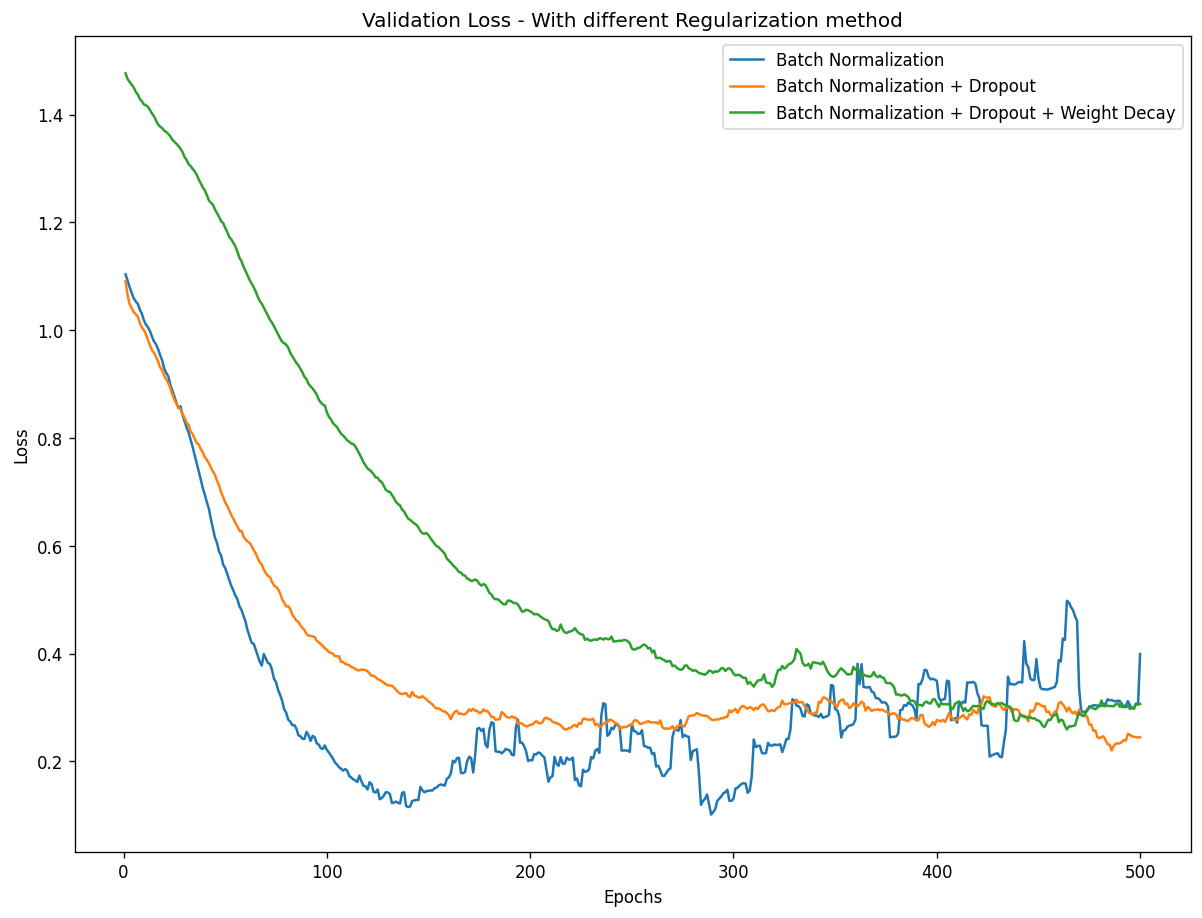

The best combination of optimizer and loss on test set after 500 epochs is Batch Normalization + Dropout with an loss and accuracy of [0.07922929525375366, 0.9555555582046509]


In [8]:
# Train model on different combinations of loss and optimizers
labels_regulizer = ["Batch Normalization", "Batch Normalization + Dropout","Batch Normalization + Dropout + Weight Decay"]
regulize_arr=[[True,False,False],[True,True,False],[True,True,True]]
best_combo = ""
best_combo_value = float("inf")
eps = 500
plt.figure(num=None, figsize=(12, 9), dpi=120, facecolor='w', edgecolor='k')
modelList = []
for i, param_reg in enumerate(regulize_arr):
    res = build_model2(param_reg[0],param_reg[1],param_reg[2])
    res.fit(X_train,Y_train,epochs=eps,batch_size=64, validation_data=(X_val,Y_val),verbose=0)
    modelList.append(res)
    val_loss_values = res.history.history['val_loss']
    eval = res.evaluate(X_test,Y_test)
    if eval[0] < best_combo_value:
      best_combo_value = eval[0] 
      best_combo = labels_regulizer[i]
      best_eval = eval
    epochs = range(1,len(val_loss_values)+1)
    plt.plot(epochs,val_loss_values,label =  labels_regulizer[i])
    print("Test Results:{}: {}".format(labels_regulizer[i],eval))

tittle_main = 'Validation Loss - With different Regularization method'
plt.title(tittle_main)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Classification_with_regulization.png')
plt.show()
print("The best combination of optimizer and loss on test set after {} epochs is {} with an loss and accuracy of {}".format(eps,best_combo,best_eval))

In [9]:
# Ensemble Classification
y_predicted =  np.array([model.predict(X_test) for model in modelList])
summed = np.sum(y_predicted,axis=0)
result = np.argmax(summed,axis=1)
print("Ensemble Classification Accuracy: {}".format(accuracy_score(np.argmax(Y_test,axis=1),result)))

Ensemble Classification Accuracy: 0.9555555555555556


# Single Output Regression

In [10]:
# Step 1: Load the data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', header = None)
avgs = []

# finding the average of each columns
for i in range (len(df.columns)):
  count = 0
  sum = 0
  for j in df[i]:
   if j!=("?"):
     try:
          var = float(j)
          sum += (var)
          count+=1
     except:
       pass
  try: 
    avg = sum/count
    avgs.append(avg)
  except:
    avgs.append(0)
    pass

# If the cell is "?" replace by the average of the column
for i in range (len(df.columns)):
  for j in range (len(df[i])):
   if (df.iloc[j,i])==("?"):
     df.iloc[j,i] = avgs[i]
   else:
     try:
      (df.iloc[j,i]) = float(df.iloc[j,i])
     except:
       pass

In [11]:
# Step 2: Prepare the data
# drop the non-numerical column
df = df.drop(df.columns[3], axis = 1)
# normalize columns by subtracting the mean and dividing by the standard deviation

In [12]:
def load_crime_data(df):
  ys = df.iloc[:,-1:].to_numpy()
  ys = np.asarray(ys).astype(np.float32)
  xs = df.iloc[:,0:127].to_numpy()
  xs = np.asarray(xs).astype(np.float32)
  # Normalize the data
  xs -= xs.mean()
  xs /= xs.std()
  return xs, ys

xs,ys= load_crime_data(df)

In [13]:
# Step 2: Create testing set
x_train2 = xs[:1395]
x_test2 = xs[1395:]
y_train2 = ys[:1395]
y_test2 = ys[1395:]
x_val2 = x_train2[977:]
x_train2 = x_train2[:977]
y_val2 = y_train2[977:]
y_train2 = y_train2[:977]

In [14]:
# Defining a model with optimizer and loss as parameters
def build_model3(opt,los):
  model = models.Sequential()
  model.add(layers.Dense(16,input_shape = (127,)))
  model.add(layers.Dense(32,activation="relu"))
  model.compile(optimizer=str(opt),loss=str(los),metrics=["mae"])
  return model

19/19 [==============================] - 0s 1ms/step - loss: 0.0644 - mae: 0.1841
Test Results:sgd-mse: [0.0644175186753273, 0.18405196070671082]
Time taken:4.241266250610352
19/19 [==============================] - 0s 1ms/step - loss: 0.1893 - mae: 0.1893
Test Results:sgd-mae: [0.18930268287658691, 0.18930268287658691]
Time taken:4.0462188720703125
19/19 [==============================] - 0s 2ms/step - loss: 0.0331 - mae: 0.1905
Test Results:sgd-logcosh: [0.03311243653297424, 0.1905229538679123]
Time taken:4.285945653915405
19/19 [==============================] - 0s 2ms/step - loss: 0.0532 - mae: 0.1803
Test Results:rmsprop-mse: [0.05324608087539673, 0.18031662702560425]
Time taken:4.513770818710327
19/19 [==============================] - 0s 1ms/step - loss: 0.1598 - mae: 0.1598
Test Results:rmsprop-mae: [0.15983204543590546, 0.15983204543590546]
Time taken:4.344969749450684
19/19 [==============================] - 0s 2ms/step - loss: 0.0247 - mae: 0.1824
Test Results:rmsprop-logcos

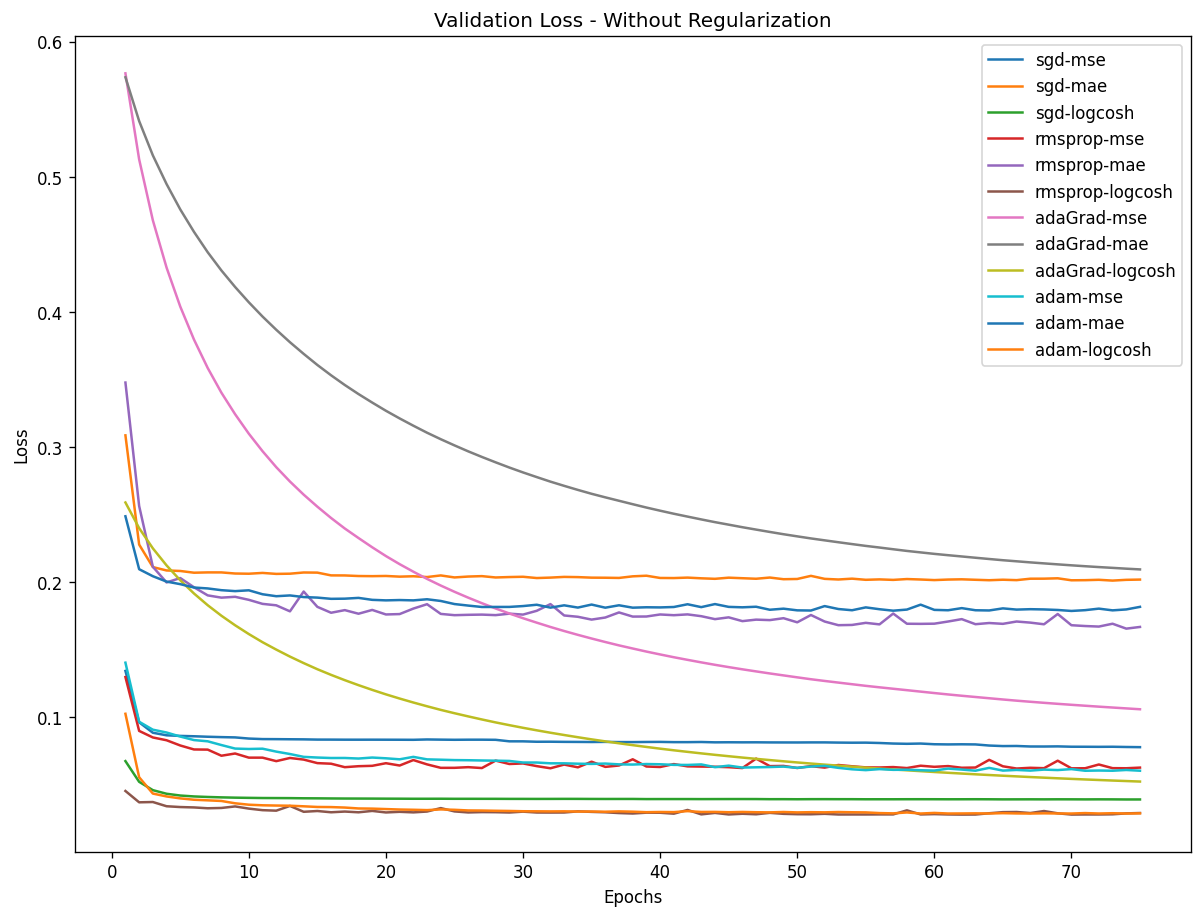

The best combination of optimizer and loss on test set after 75 epochs is adam-logcosh with an loss and accuracy of [0.024628326296806335, 0.17506197094917297]


In [15]:
# Train model on different combinations of loss and optimizers
labels_optimizers = ['sgd','rmsprop','adaGrad','adam']
labels_losses = ['mse','mae','logcosh']
best_combo = ""
best_combo_value = float("inf")
eps = 75
plt.figure(num=None, figsize=(12, 9), dpi=120, facecolor='w', edgecolor='k')
for i, param_opt in enumerate(labels_optimizers):
  for j, param_los in enumerate(labels_losses):
    res = build_model3(param_opt,param_los)
    start_time = t.time()
    res.fit(x_train2,y_train2,epochs=eps,batch_size=64, validation_data=(x_val2,y_val2),verbose=0)
    end_time = t.time()
    time_taken = end_time-start_time
    val_loss_values = res.history.history['val_loss']
    eval = res.evaluate(x_test2,y_test2)
    if eval[0] < best_combo_value:
      best_combo_value = eval[0] 
      best_combo = labels_optimizers[i]+ '-' +labels_losses[j]
      best_eval = eval
    epochs = range(1,len(val_loss_values)+1)
    plt.plot(epochs,val_loss_values,label =  labels_optimizers[i]+ '-' +labels_losses[j])
    print("Test Results:{}-{}: {}\nTime taken:{}".format(labels_optimizers[i],labels_losses[j],eval,time_taken))

tittle_main = 'Validation Loss - Without Regularization'
plt.title(tittle_main)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Regression_with_loss_and_optimizers.png')
plt.show()
print("The best combination of optimizer and loss on test set after {} epochs is {} with an loss and accuracy of {}".format(eps,best_combo,best_eval))

In [16]:
# The graph shows that the combination more prone to overfitting is rmsprop and mse. Therefore we will work on generelizing it.
# Defining a model with weight decay, droupout, and batch normalization as parameters
def build_model4(bn,do,wd):
  model = models.Sequential()
  model.add(layers.Dense(16,input_shape = (127,)))
  if bn:
    model.add(BatchNormalization())
  if not wd:
    model.add(layers.Dense(32,activation="relu"))
  else:
    model.add(layers.Dense(32,activation="relu",kernel_regularizer=l2(0.001)))
  if do:
    model.add(Dropout(0.9))
  model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
  return model

19/19 [==============================] - 0s 2ms/step - loss: 0.0973 - mae: 0.2264
Test Results:Batch Normalization: [0.09730049967765808, 0.2264440506696701]
Time taken:5.400559902191162
19/19 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.2141
Test Results:Batch Normalization + Dropout: [0.08697431534528732, 0.21408814191818237]
Time taken:5.416217088699341
19/19 [==============================] - 0s 2ms/step - loss: 0.0991 - mae: 0.2264
Test Results:Batch Normalization + Dropout + Weight Decay: [0.09911040961742401, 0.2264440506696701]
Time taken:5.5034332275390625


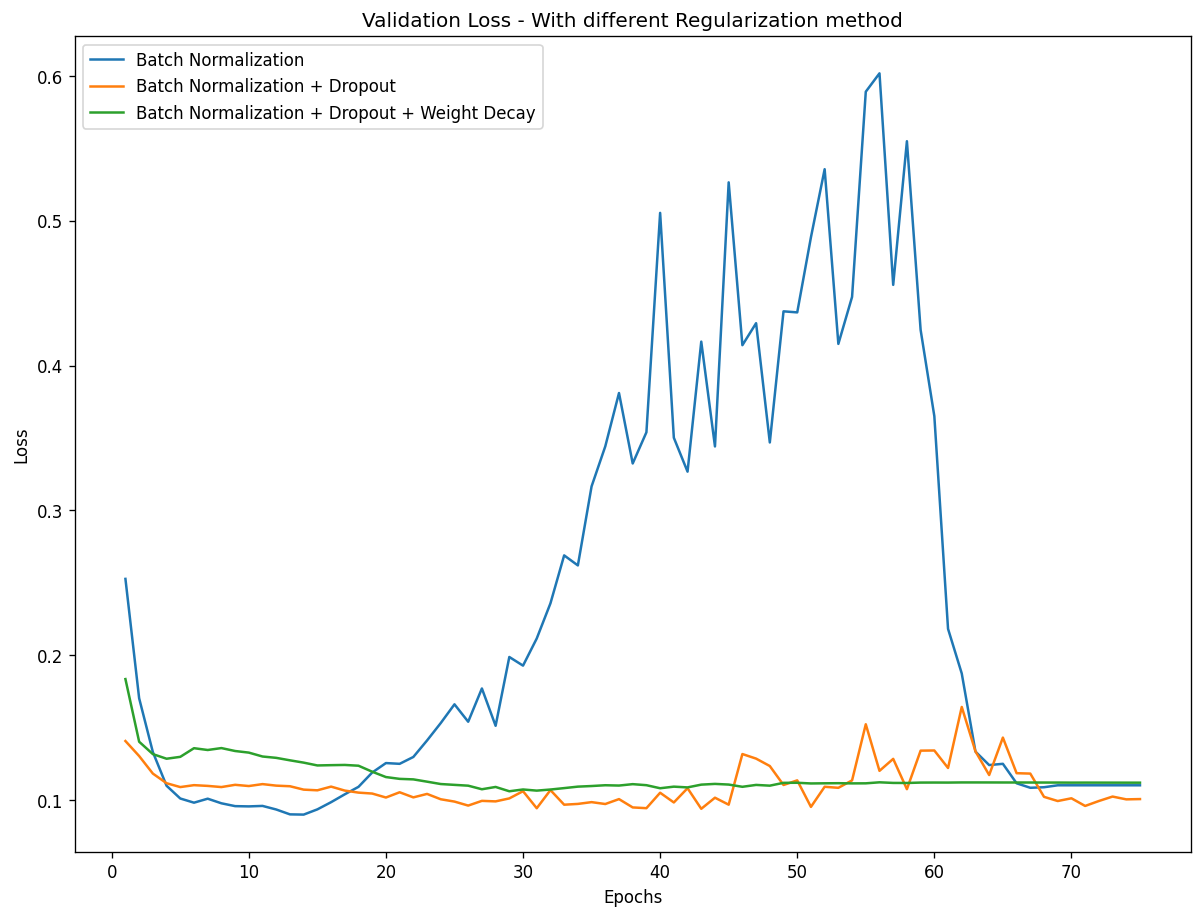

The best combination of Regularization technique on test set after 75 epochs is Batch Normalization + Dropout with an loss and an MAE of [0.08697431534528732, 0.21408814191818237]


In [17]:
# Train model on different combinations of loss and optimizers
labels_regulizer = ["Batch Normalization", "Batch Normalization + Dropout","Batch Normalization + Dropout + Weight Decay"]
regulize_arr=[[True,False,False],[True,True,False],[True,True,True]]
best_combo = ""
best_combo_value = float("inf")
eps = 75
plt.figure(num=None, figsize=(12, 9), dpi=120, facecolor='w', edgecolor='k')
modelList = []
for i, param_reg in enumerate(regulize_arr):
    res = build_model4(param_reg[0],param_reg[1],param_reg[2])
    start_time = t.time()
    res.fit(x_train2,y_train2,epochs=eps,batch_size=64, validation_data=(x_val2,y_val2),verbose=0)
    end_time = t.time()
    time_taken = end_time-start_time
    modelList.append(res)
    val_loss_values = res.history.history['val_loss']
    eval = res.evaluate(x_test2,y_test2)
    if eval[0] < best_combo_value:
      best_combo_value = eval[0] 
      best_combo = labels_regulizer[i]
      best_eval = eval
    epochs = range(1,len(val_loss_values)+1)
    plt.plot(epochs,val_loss_values,label =  labels_regulizer[i])
    print("Test Results:{}: {}\nTime taken:{}".format(labels_regulizer[i],eval,time_taken))

tittle_main = 'Validation Loss - With different Regularization method'
plt.title(tittle_main)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Regression_with_regularization.png')
plt.show()
print("The best combination of Regularization technique on test set after {} epochs is {} with an loss and an MAE of {}".format(eps,best_combo,best_eval))

In [18]:
def mae(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error / float(len(actual))
y_predicted =  np.array([model.predict(x_test2) for model in modelList])
summed = np.sum(y_predicted,axis=0)
result = np.mean(summed,axis=1)
print("Ensemble MAE: {}".format(mae(y_test2,result)))

Ensemble MAE: [0.17571963]
